# Bitcoin prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import nltk
from collections import Counter
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import collections
from sklearn import metrics
from tensorflow.keras import models
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
#Read data set with pandas
df = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Columns name in data set
for col in df.columns:
    print("column: ",col)

column:  Timestamp
column:  Open
column:  High
column:  Low
column:  Close
column:  Volume_(BTC)
column:  Volume_(Currency)
column:  Weighted_Price


In [4]:
#Convert Timestamp to datetime.
df['Timestamp'] = pd.to_datetime(df.Timestamp, unit='s')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06
mean,4.570658e+03,4.573721e+03,4.567413e+03,4.570624e+03,9.422676e+00,3.315691e+04,4.570625e+03
std,4.775105e+03,4.778620e+03,4.771352e+03,4.775094e+03,3.101255e+01,1.129107e+05,4.775090e+03
min,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,4.321900e+02,4.324300e+02,4.320000e+02,4.322000e+02,3.917811e-01,4.147936e+02,4.321753e+02
50%,3.085010e+03,3.093250e+03,3.078010e+03,3.084410e+03,1.936719e+00,3.305199e+03,3.085478e+03
75%,8.158010e+03,8.162850e+03,8.152790e+03,8.157310e+03,7.299825e+00,2.158297e+04,8.157964e+03
max,2.899738e+04,2.901032e+04,2.896366e+04,2.899738e+04,5.853852e+03,1.044599e+07,2.898589e+04


In [6]:
# Resample the Timestamp for each hour
df_resample = df.resample('H', on='Timestamp')[['Weighted_Price']].mean()

Text(0.5, 1.0, 'data')

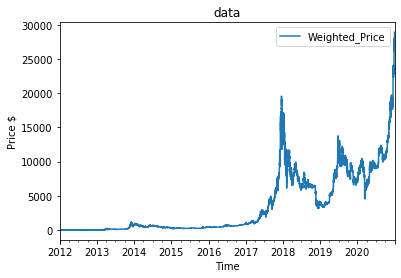

In [7]:
#Plot price with timestamp
axs = df_resample.plot()
axs.set_xlabel("Time") 
axs.set_ylabel("Price $") 
axs.set_title('data')

In [8]:
#How many of each column is Nan
df_resample.isnull().mean()

Weighted_Price    0.044762
dtype: float64

In [9]:
#Fill NaN in df
df_resample = df_resample.fillna(method = "backfill")
df_resample.isnull().mean()

Weighted_Price    0.0
dtype: float64

In [10]:
#Normalized data
scaler = MinMaxScaler()
normalized_weights = scaler.fit_transform(df_resample)

In [11]:
#Replace normalized weights in df
df_resample['Weighted_Price'] = normalized_weights
df_resample.head()

,Weighted_Price
Timestamp,
2011-12-31 07:00:00,0.000009
2011-12-31 08:00:00,0.000009
2011-12-31 09:00:00,0.000009
2011-12-31 10:00:00,0.000009
2011-12-31 11:00:00,0.000009


Text(0.5, 1.0, 'normalized data')

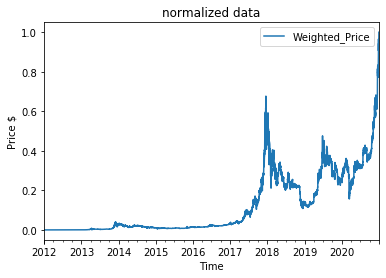

In [12]:
#Plot with normalized prices
axs = df_resample.plot()
axs.set_xlabel("Time") 
axs.set_ylabel("Price $")
axs.set_title('normalized data')

In [13]:
df_splitted = df_resample['2017-01-01':]

Text(0.5, 1.0, 'splitted data')

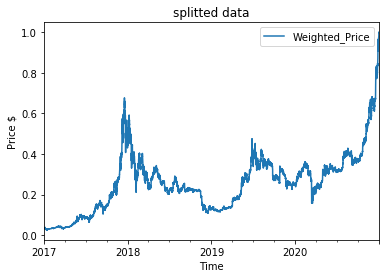

In [14]:
#Plot with splitted normalized prices
axs = df_splitted.plot()
axs.set_xlabel("Time") 
axs.set_ylabel("Price $")
axs.set_title('splitted data')

In [15]:
#Split into train and tes
start = int(len(df_splitted) * 0.8)
train_data = df_splitted.iloc[:start]
test_data = df_splitted.iloc[start:]
print("train shape", train_data.shape)
print("test shape", test_data.shape)

train shape (28032, 1)
test shape (7009, 1)


Text(0.5, 1.0, 'train data')

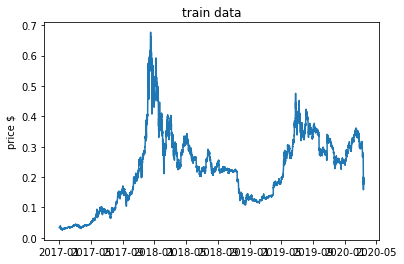

In [16]:
plt.plot(train_data)
plt.ylabel("price $")
plt.title('train data')

In [17]:
#teacher forcing shift toy data
def shifter(data,shift=12):
    x=[]
    y=[]
    for i in range(len(data)-shift):
        x.append(data[i:(i+shift)])
        y.append(data[i+shift])
    return np.array(x),np.array(y)

In [18]:
#Example
x, y = shifter(data=[1,2,3,4,5,6,7,8,9,10], shift=3)
for i in range(len(x)):
    print(x[i], y[i])

[1 2 3] 4
[2 3 4] 5
[3 4 5] 6
[4 5 6] 7
[5 6 7] 8
[6 7 8] 9
[7 8 9] 10


In [19]:
# Create input and output for df data
def shift_df(data,shift=12):
    x=[]
    y=[]
    for i in range(len(data)-shift):
        x.append(data.iloc[i:(i+shift)])
        y.append(data.iloc[i+shift])
    return np.array(x),np.array(y)

In [20]:
shift=12
x_train, y_train = shift_df(data=train_data, shift=shift)
x_test, y_test = shift_df(data=test_data, shift=shift)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (28020, 12, 1)
y_train shape:  (28020, 1)
x_test shape:  (6997, 12, 1)
y_test shape:  (6997, 1)


Text(0.5, 1.0, 'test data')

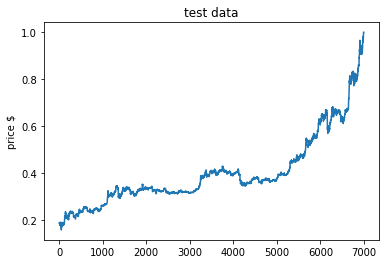

In [21]:
plt.plot(y_test)
plt.ylabel("price $")
plt.title('test data')

In [22]:
#LSTM model
lstm_out = 32
timestep = x_train.shape[1]
#adam = Adam(lr=0.00001)

model = models.Sequential()
model.add(LSTM(lstm_out, input_shape=(timestep,1),activation='relu', return_sequences = False))
#model.add(LSTM(64,return_sequences = True))
#model.add(LSTM(32,return_sequences = True))
#model.add(LSTM(8,return_sequences = False))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()
history =model.fit(x_train, y_train, batch_size=64, epochs=10, shuffle=False, verbose =1,
                  validation_split=0.2,
                  ).history

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 22416 samples, validate on 5604 samples
Epoch 1/10
22416/22416 [==============================] - 12s 531us/sample - loss: 4.7301e-04 - val_loss: 0.0025
Epoch 2/10
22416/22416 [==============================] - 7s 309us/sample - loss: 0.0014 - val_loss: 0.0031
Epoch 3/10
22416/22416 [==============================] - 7s 310us/samp

In [23]:
#Predictions
y_pred = model.predict(x_test)

Text(0.5, 1.0, 'test data')

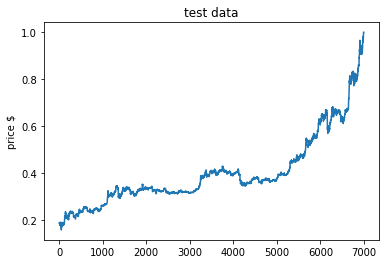

In [24]:
#Visulize predictions
plt.plot(y_test)
plt.ylabel("price $")
plt.title('test data')

Text(0.5, 1.0, 'predicted data')

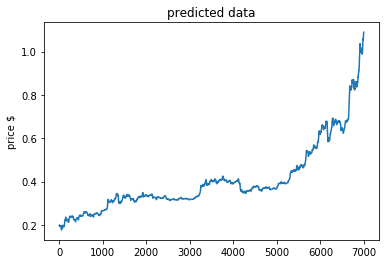

In [25]:
plt.plot(y_pred)
plt.ylabel("price $")
plt.title('predicted data')

In [26]:
y_test_reversed = scaler.inverse_transform(y_test)
y_pred_reversed = scaler.inverse_transform(y_pred)

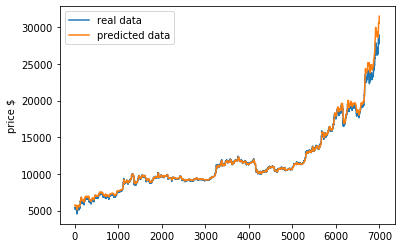

In [27]:
plt.plot(y_test_reversed, label="real data")
plt.ylabel("price $")
plt.plot(y_pred_reversed, label="predicted data")
plt.ylabel("price $")
plt.legend(loc="upper left")

In [28]:
test_data_index = test_data[shift:]
test_data_index['y_test'] = y_test_reversed
test_data_index['y_pred'] = y_pred_reversed
test_data_index = test_data_index.drop(columns=['Weighted_Price'])

c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


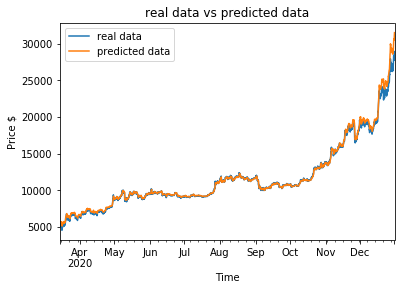

In [29]:
axs = test_data_index.plot()
axs.set_xlabel("Time") 
axs.set_ylabel("Price $")
axs.set_title('real data vs predicted data')
axs.legend(["real data", "predicted data"], loc='upper left')

In [59]:
#Predict future unseen prices
future_prices = []
pattern = list(np.array(x_test[-1:]).flatten())
#pattern = list(np.array(y_test[-12:]))
# generate future prices
for i in range(500):
    x = np.reshape(pattern, (1, len(pattern), 1))
    prediction = model.predict(x)
    prediction = prediction[0][0] * np.random.uniform(0.7, 1.3)
    prediction = np.clip(prediction, 0.2, 1.6)
    pattern.append(prediction)
    future_prices.append(prediction)
    pattern = pattern[1:len(pattern)]
    

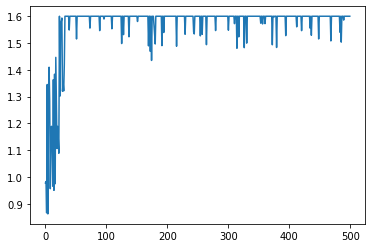

In [60]:
plt.plot(future_prices, label="predicted future unseen data")

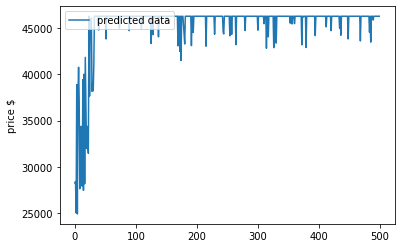

In [61]:
future_prices = np.array(future_prices)
future_prices = future_prices.reshape(-1,1)
future_prices = scaler.inverse_transform(future_prices)
plt.plot(future_prices, label="predicted data")
plt.ylabel("price $")
plt.legend(loc="upper left")